In [ ]:
from glob import glob
import nltk
import numpy as np
import re
from collections import Counter
from math import sqrt

In [2]:
with open('topic-words.txt', 'r') as f:
    """
    topic-words.txt has a format like this:
    
    stonefruit: apricot apricots nectar nectarine nectarines peach peaches
    peachy plum plums
    
    different topic words are separated by blank lines, and comments start with a #
    """
    raw = f.read().split("\n\n")
    
    categories = [ s.split() for s in raw if re.match(r'^\w+:', s) ]
    
    category_names = [ c[0][:-1] for c in categories ]
    category_data  = [ c[1:] for c in categories ]

In [3]:
def tokenize_scotch(fname):
    """read the text file containing reviews for a scotch, and tokenize into topic words"""
    with open(fname, 'r') as f:
        raw = nltk.word_tokenize(f.read().lower())

    c = Counter(raw)

    # unclear how to weight this... mean penalizes categories with 
    # many terms.  use the sqrt as a compromise
    fingerprint = [ np.sum([ c[token] for token in tokens ]) / sqrt(len(tokens))
                    for tokens in category_data ]
    
    fingerprint = np.array(fingerprint, dtype=np.float)
    norm = sqrt(np.dot(fingerprint, fingerprint))
    
    return fingerprint / norm

In [4]:
# top 100 most-reviewed scotches.
files =  glob('Reviews/*.txt')
scotch_names = [ s.replace('Reviews/', '').replace('.txt', '').replace('-', ' ')
                for s in files ]
corpus = [ tokenize_scotch(f) for f in files ]

In [5]:
# next 100 most-reviewed scotches.
# i haven't gone through these, so many files contain reviews from other scotches!
files2 =  glob('Reviews-2/*.txt')
scotch_names2 = [ s.replace('Reviews-2/', '').replace('.txt', '').replace('-', ' ')
                for s in files2 ]
corpus2 = [ tokenize_scotch(f) for f in files2 ]

files = files + files2
scotch_names = scotch_names + scotch_names2
corpus = corpus + corpus2

In [6]:
import pandas as pd

scotch_traits_df = pd.DataFrame(corpus,
                                columns=category_names,
                                index=scotch_names)

In [7]:
def print_scotch_traits(scotch):
    s = pd.Series(scotch_traits_df.loc[scotch])
    print scotch, ":"
    print s[s > 0].sort_values(ascending=False)[:10]

In [8]:
print_scotch_traits('Laphroaig 10')

Laphroaig 10 :
peat         0.487013
medicinal    0.442762
vanilla      0.440020
smoke        0.314022
bold         0.245979
sea          0.158779
hay          0.147587
salt         0.146673
sugar        0.142901
smooth       0.122989
Name: Laphroaig 10, dtype: float64


In [9]:
def print_similar_scotches(scotch):
    similar = [ (s, np.dot(scotch_traits_df.loc[scotch],
                           scotch_traits_df.loc[s]))
               for s in scotch_names if s != scotch ]

    similar = sorted(similar, 
                     key = lambda item: item[1],
                     reverse = True)
    
    similar = [ s for s, rank in similar ]

    print "most similar to", scotch, ":"
    print ", ".join(similar[:10])

In [10]:
print_similar_scotches('Laphroaig 10')

most similar to Laphroaig 10 :
Laphroaig 10 Cask Strength, Caol Ila 12, Kilchoman Machir Bay, Laphroaig Cairdeas 2015, Laphroaig Select, Laphroaig 18, Laphroaig Quarter Cask, Laphroaig Lore, Bruichladdich Port Charlotte Scottish Barley, Ardbeg 10


In [11]:
from sklearn.cluster import KMeans

est = KMeans(n_clusters=9)
est.fit(corpus)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
kmeans_group_labels = est.labels_

groups = sorted(zip(scotch_names, kmeans_group_labels),
                key = lambda item: item[1])

kmeans_groups = []
for l in set(kmeans_group_labels):
    temp = [ name for name, label in groups if label == l ]
    kmeans_groups.append(temp)

In [13]:
def get_scotch_traits(scotch):
    s = pd.Series(scotch_traits_df.loc[scotch])
    return np.array(s)

def get_common_traits(scotches):
    data = [ get_scotch_traits(scotch) for scotch in scotches ]
    data = np.mean(data, axis=0)
    
    ind = np.flipud(data.argsort())[:5]
    
    return [ category_names[i] for i in ind ]

In [14]:
kmeans_group_traits = [ ', '.join(get_common_traits(res)) 
                       for res in kmeans_groups ]

In [15]:
kmeans_group_traits

['wine, sugar, vanilla, fruit, sherry',
 'sherry, sugar, oak, fruit, spice',
 'peat, sugar, smoke, vanilla, salt',
 'oak, vanilla, sherry, apple, fruit',
 'vanilla, peat, smoke, salt, sugar',
 'sherry, vanilla, oak, sugar, fruit',
 'vanilla, sugar, apple, oak, honey',
 'sherry, peat, sugar, smoke, vanilla',
 'vanilla, easy, honey, citrus, beer']

In [89]:
# download latest spreadsheet...
archive_url = r'https://docs.google.com/spreadsheets/d/1X1HTxkI6SqsdpNSkSSivMzpxNT-oeTbjFFDdEkXD30o/export?exportFormat=csv'
scoth_review_archive_df = pd.read_csv(archive_url)

In [16]:
# or use the local copy...
scoth_review_archive_df = pd.read_csv('archive.csv')

In [17]:
def get_region(scotch):
    df = scoth_review_archive_df
    temp = df[df['Whisky Name'] == scotch]

    region, cnt = Counter(temp['Whisky Region or Style']).most_common(1)[0]
    return region

scotch_regions = map(get_region, scotch_names)

Counter(scotch_regions)

Counter({'Highland': 31, 'Island': 27, 'Islay': 66, 'Speyside': 70})

In [18]:
from sklearn import decomposition
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [97]:
np.arange(X.shape[1])+1

array([1, 2, 3])

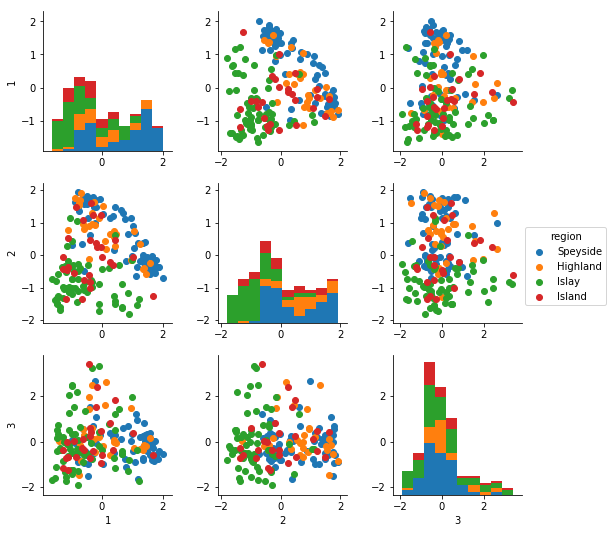

In [101]:
pca = decomposition.PCA(n_components=3, whiten=True)
pca.fit(corpus)
X = pca.transform(corpus)

df3 = pd.DataFrame(X, columns=(np.arange(X.shape[1])+1))
df3['region'] = scotch_regions

g = sns.PairGrid(df3, hue='region')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [102]:
g.savefig('static/pca-by-region.png', transparent=True)

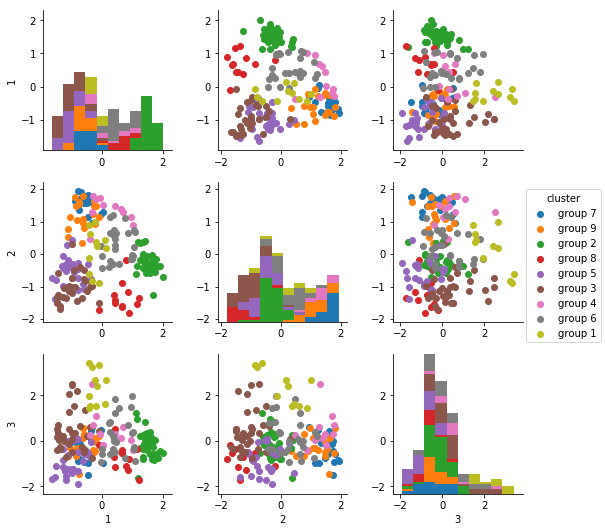

In [103]:
df3['cluster'] = [ "group {0:d}".format(l+1) for l in kmeans_group_labels ]
g = sns.PairGrid(df3, hue='cluster')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

In [104]:
g.savefig('static/pca-by-kmeans.png', transparent=True)

In [20]:
def format_pca(v):
    v = (v - np.mean(v)) / (np.max(v) - np.min(v))

    ind = np.flipud(v.argsort())
    
    keep = np.concatenate((ind[:5], ind[-5:]))

    terms = [ "{0:.2f} {1:s}".format(x, trait) for x, trait in
             zip(v[keep],
                 [ category_names[i] for i in keep ]) ]

    return " + ".join(terms)

In [21]:
equations = map(format_pca, pca.components_)

In [22]:
result = \
[ "{0:.2f}: {1:s}".format(importance, equation) 
 for importance, equation in 
 zip(pca.explained_variance_ratio_, equations) ]

In [23]:
print "\n\n".join(result)

0.30: 0.71 sherry + 0.09 raisin + 0.08 oak + 0.07 spice + 0.07 berry + -0.07 medicinal + -0.13 salt + -0.16 smoke + -0.19 vanilla + -0.29 peat

0.16: 0.39 vanilla + 0.34 oak + 0.28 apple + 0.27 honey + 0.16 easy + -0.16 salt + -0.18 medicinal + -0.27 sherry + -0.35 smoke + -0.61 peat

0.06: 0.56 wine + 0.21 oak + 0.17 fruit + 0.15 berry + 0.12 cocoa + -0.11 honey + -0.12 medicinal + -0.12 easy + -0.27 sherry + -0.44 vanilla


In [24]:
def my_pc1(scotch):
    df = scotch_traits_df
    terms = (df.loc[scotch])[['sherry', 'raisin', 'berry', 'spice', 'vanilla', 'caramel', 'toffee']]
    weights = [0.74, 0.10, 0.07, 0.07, -0.18, -0.18, -0.0018]
    return np.dot(terms, weights)

def my_pc2(scotch):
    df = scotch_traits_df
    terms = (df.loc[scotch])[['peat', 'smoke', 'apple', 'honey', 'heather']]
    weights = [0.65, 0.41, -0.27, -0.28, -0.28]
    return -np.dot(terms, weights)

In [25]:
ys = map(my_pc1, scotch_names)
xs = map(my_pc2, scotch_names)

In [26]:
import bokeh
import bokeh.palettes

kmeans_pal = bokeh.palettes.brewer['Set3'][len(kmeans_groups)]
region_pal = bokeh.palettes.d3['Category10'][len(set(scotch_regions))]

def color_by_region(region):
    temp = sorted(set(scotch_regions))
    return region_pal[temp.index(region)]

def print_scotch_traits(scotch):
    s = pd.Series(scotch_traits_df.loc[scotch])
    s = s[s > 0].sort_values(ascending=False)[:5]
    return ", ".join(s.index)

In [27]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def get_price_and_rating(scotch):
    tmp = scoth_review_archive_df.loc[lambda df: df['Whisky Name'] == scotch]    

    prices = [ float(price)
              for price in pd.Series(tmp['Full Bottle Price Paid'])
              if type(price) == str and is_number(price) ]

    ratings = [ float(rating) 
               for rating in pd.Series(tmp['Reviewer Rating'])
               if type(rating) == str and is_number(rating) ]
    
    # some people rate out of 10; most out of 100...
    ratings = map(lambda r: 10*r if r<=10 else r, ratings)
    
    if len(prices) == 0:
        prices = [np.nan]
    if len(ratings) == 0:
        ratings = [np.nan]
    
    return (int(np.median(prices)), int(np.median(ratings)))

In [28]:
temp = map(get_price_and_rating, scotch_names)

scotch_prices  = [ price  for price, rating in temp ]
scotch_ratings = [ rating for price, rating in temp ]

In [29]:
bokeh_df = pd.DataFrame({'name' : scotch_names,
                         'pc_x' : xs,
                         'pc_y' : ys,
                         'region': scotch_regions,
                         'region-color' : [ color_by_region(r) for r in scotch_regions ],
                         'kmeans-label' : kmeans_group_labels,
                         'kmeans-color' : [ kmeans_pal[i] for i in kmeans_group_labels ],
                         'traits' : map(print_scotch_traits, scotch_names),
                         'price'  : [ "${0:d}".format(p) for p in scotch_prices ],
                         'rating' : scotch_ratings
                        })

from bokeh.models import ColumnDataSource
source = ColumnDataSource(bokeh_df)

In [83]:
from bokeh.models import HoverTool, LinearAxis, Range1d
from bokeh.plotting import figure, show, output_file
from bokeh.models.tickers import FixedTicker

hover = HoverTool(tooltips=[("name", "@name"),
                            ("region", "@region"),
                            ("traits", "@traits"),
                            ("price", "@price"),
                            ("rating", "@rating")])

p = figure(tools=[hover], 
           plot_width=600, 
           title='')

p.toolbar.logo = None
p.toolbar_location = None

p.border_fill_color = "#fdf6e3"
p.border_fill_alpha = 0.0
p.background_fill_color= "#eee8d5" #"#fdf6e3" #"#dddddd"
p.grid.visible = False

p.xaxis.axis_label="vanilla, caramel, apricot"
p.yaxis.axis_label="peat, smoke"
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "15pt"

no_ticks = FixedTicker(ticks=[])

p.xaxis.ticker = no_ticks
p.yaxis.ticker = no_ticks

p.extra_y_ranges = {"foo": Range1d(start=-1, end=1)}
p.add_layout(LinearAxis(y_range_name="foo", 
                        ticker=no_ticks, 
                        axis_label="apple, honey, heather",
                        axis_label_text_font_size = "15pt"),
             'right')

p.extra_x_ranges = {"bar": Range1d(start=-1, end=1)}
p.add_layout(LinearAxis(x_range_name="bar", 
                        ticker=no_ticks, 
                        axis_label="sherry, raisin, spice, berry",
                        axis_label_text_font_size = "14pt"
                       ),
             'above')

p.circle("pc_x", "pc_y", size=12, source=source,
         color='kmeans-color', line_color="black", fill_alpha=0.8)

#output_file("scotch.html", title="scotch landscape")

#show(p)

GlyphRenderer(id='b1871ee2-011b-4fad-bcfd-36e60445d04e', ...)

In [84]:
bokeh_legend_df = pd.DataFrame({ 'traits' : kmeans_group_traits,
                                 'color'  : [ kmeans_pal[i] for i in range(len(kmeans_group_traits)) ],
                                 'x' : 0,
                                 'y' : range(len(kmeans_group_traits))})

legend_source = ColumnDataSource(bokeh_legend_df)

In [85]:
from bokeh.models import LabelSet

l = figure(plot_width=220, 
           tools='',
           title='',
           x_range = (-1, 10))

l.toolbar.logo = None
l.toolbar_location = None

l.border_fill_color = "#fdf6e3"
l.border_fill_alpha = 0.0
l.background_fill_color= "#eee8d5" #"#fdf6e3" #"#dddddd"
l.grid.visible = False

l.xaxis.ticker = no_ticks
l.yaxis.ticker = no_ticks
l.xaxis.visible = False
l.yaxis.visible = False 
l.outline_line_color = None



l.circle("x", "y", size=12, source=legend_source,
         color='color', line_color="black", fill_alpha=0.8)

labels = LabelSet(x="x", y="y", text="traits", x_offset=15,
                  text_baseline='middle',
                  text_font_size="8pt", text_color="#555555",
                  source=legend_source, text_align='left')
l.add_layout(labels)

#output_file("scotch-legend.html", title="legend")

#show(l)

In [86]:
from bokeh.layouts import row

output_file("scotch.html", title="scotch landscape")

p2 = row(p, l, sizing_mode='fixed')

show(p2)

In [87]:
from bokeh.embed import autoload_static
from bokeh.resources import CDN

js, tag = autoload_static(model = p2, resources = CDN, 
                          script_path = 'static/scotch-plot.js')

with open('static/scotch-plot.js', 'w') as jsfile:
    jsfile.write(js)

print(tag)


<script
    src="static/scotch-plot.js"
    id="360180b8-4301-4a7e-b4b4-78b833a1ceea"
    data-bokeh-model-id="a2b84b77-3d5a-4467-bf5d-eaf56cfe2b1a"
    data-bokeh-doc-id="6cc89c7d-f95c-42f8-b720-cdc7c83684f2"
></script>
